# Data Surgery 5: Multi-Dimensional Images and Clustering Analysis

Semi-autimatic identification of distinct regions in multi-dimensional spatially resolved data.

In [2]:
import glob, os
import numpy as np

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 150

## Data Import

The data are 512x512 grids of tab-delimited numbers, with each element stored in a separate file. We'll import all the data into a [dictionary](https://docs.python.org/3.6/tutorial/datastructures.html#dictionaries), with each grid of data linked to its element name.

**Assumption:** That each pixel in the 512x512 grid is from exactly the same location on the sample.

In [16]:
ps = glob.glob('data/maps/*.txt') # find all text files in data folder

dat = {}  # create an empty dictionary
for p in ps:
    el = p.split('/')[-1].replace('.txt','')  # extract the element name from the file name
    dat[el] = np.genfromtxt(p)  # load data

In [17]:
# look at the data
dat

{'Al': array([[  95.,   91.,   83., ...,   94.,   93.,   85.],
        [  89.,   95.,   81., ...,  118.,  108.,   84.],
        [ 102.,   89.,   98., ...,  120.,  113.,   83.],
        ..., 
        [   1.,    0.,    0., ...,   75.,   61.,    3.],
        [   0.,    0.,    1., ...,   67.,   83.,    2.],
        [  78.,   58.,   72., ...,   93.,  119.,   65.]]),
 'Ca': array([[ 45.,  58.,  53., ...,  47.,  62.,  38.],
        [ 47.,  46.,  49., ...,  59.,  67.,  53.],
        [ 40.,  48.,  48., ...,  65.,  54.,  43.],
        ..., 
        [  1.,   0.,   0., ...,   1.,   1.,   1.],
        [  0.,   0.,   1., ...,   1.,   1.,   0.],
        [ 44.,  28.,  51., ...,  68.,  67.,  39.]]),
 'Fe': array([[ 10.,   4.,   5., ...,   7.,   8.,   9.],
        [  8.,   2.,   6., ...,   7.,   6.,   9.],
        [  7.,   7.,   4., ...,   5.,   5.,  14.],
        ..., 
        [  0.,   0.,   0., ...,   4.,   2.,   0.],
        [  0.,   0.,   0., ...,   6.,   5.,   0.],
        [  4.,   8.,   7., ...,  

## Look at the images

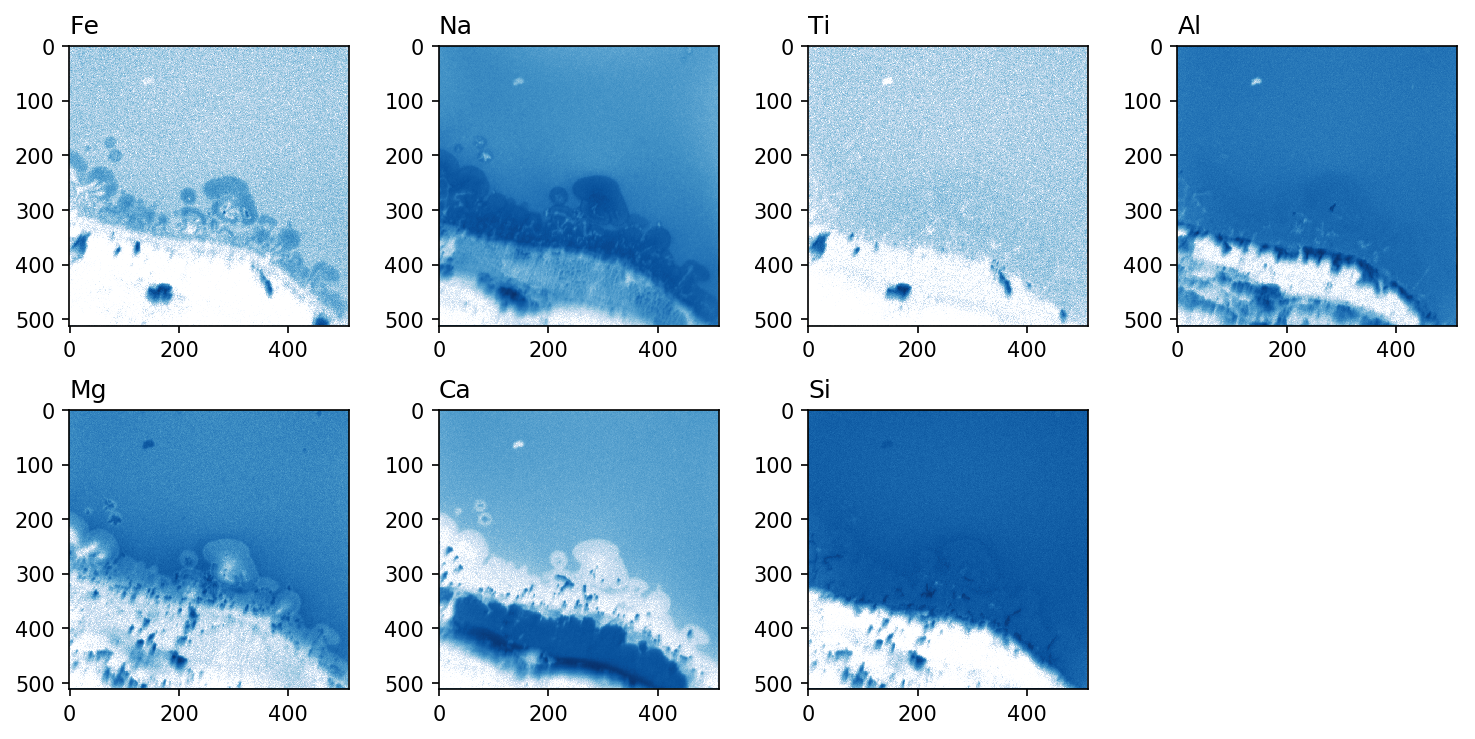

In [18]:
fig, axs = plt.subplots(2, 4, figsize=[10, 5])  # create figure with multiple axes

# plot all elements
i = 0
for ax, (k, v) in zip(axs.flat, dat.items()):
    ax.imshow(v, cmap=plt.cm.Blues, norm=LogNorm())
    ax.set_title(k, loc='left')
    i += 1

# remove unused axes
for ax in axs.flatten()[i:]:
    ax.set_visible(False)

fig.tight_layout()

### Noise Removal?

Some of the images (e.g. Fe, Ti) are pretty noisy. This will interfere with using these elements to identify different materials. To ameliorate this, we'll smooth the data before we use it to identify different regions.

**Note:** By smoothing, you might blur material edges, and lose useful information in the images. In this case, we're going to use the smoothed data to identify the different regions, by apply the resulting masks to the *original* data, so we don't lose any useful information.

In [21]:
import scipy.signal as sig
from scipy.stats import multivariate_normal

In [25]:
# create a 5x5 gaussian kernel
kernel_size = 5
kernel = np.ones((kernel_size, kernel_size))
kernel /= kernel.sum()

# convolve the kernel with the image data
sdat = {}
for k, v in dat.items():
    sdat[k] = sig.convolve2d(v, kernel, mode='valid')

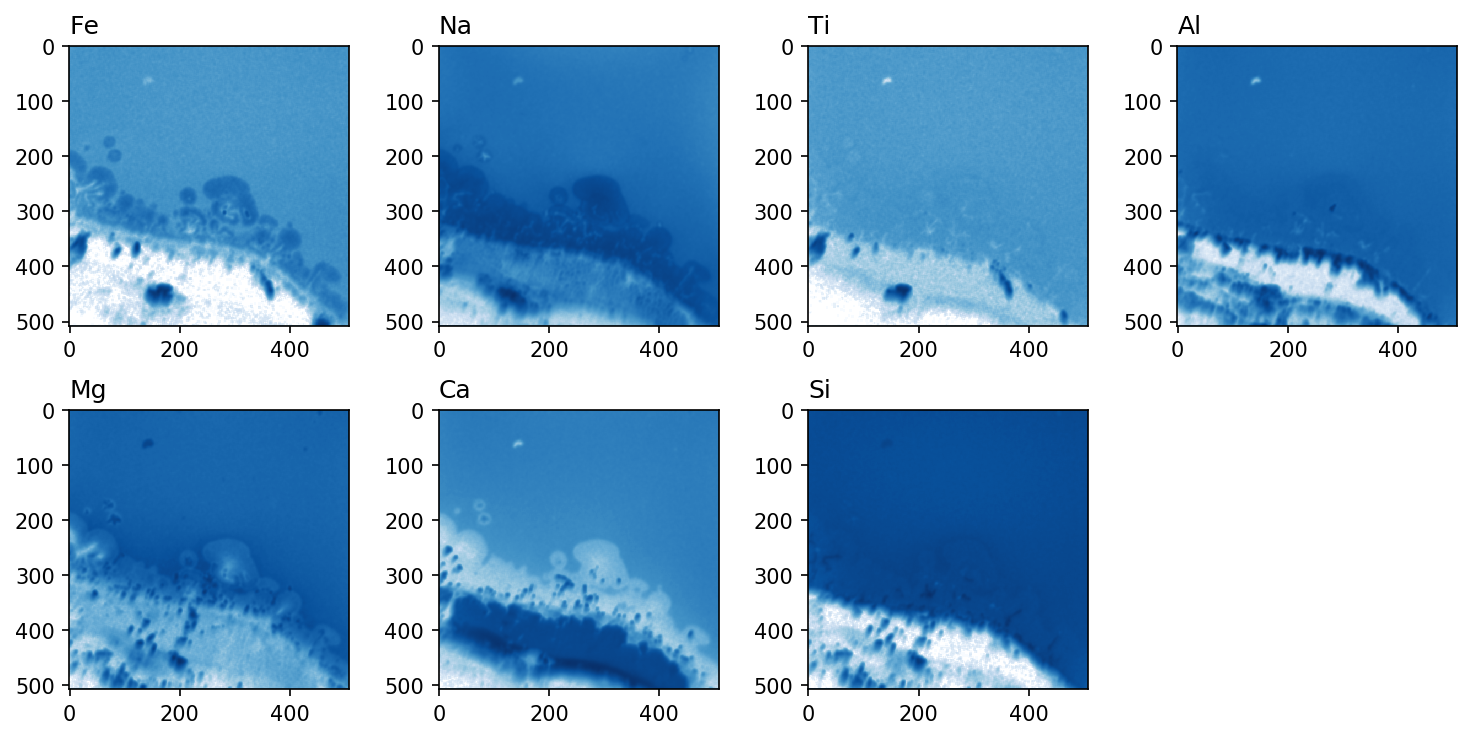

In [26]:
fig, axs = plt.subplots(2, 4, figsize=[10, 5])

i = 0
for ax, (k, v) in zip(axs.flat, sdat.items()):
    ax.imshow(v, cmap=plt.cm.Blues, norm=LogNorm())
    ax.set_title(k, loc='left')
    i += 1

for ax in axs.flatten()[i:]:
    ax.set_visible(False)

fig.tight_layout()

## Data distribution in each image

Plot all the data in each image as a histogram, so we can see which elements show the most difference between materials.

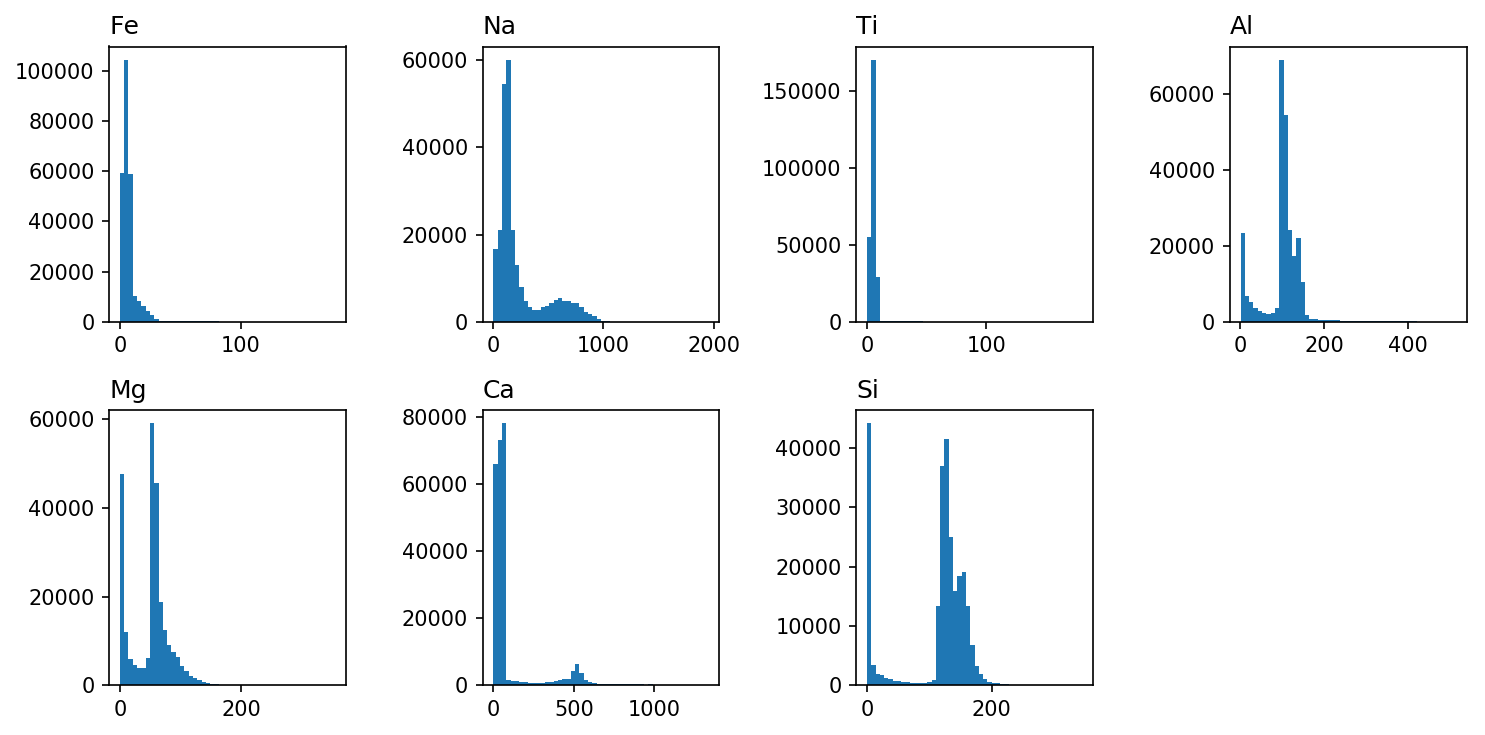

In [28]:
fig, axs = plt.subplots(2, 4, figsize=[10, 5])

i = 0
for ax, (k, v) in zip(axs.flat, sdat.items()):
    ax.hist(v.ravel(), bins=50)
    ax.set_title(k, loc='left')
    i += 1

for ax in axs.flatten()[i:]:
    ax.set_visible(False)

fig.tight_layout()

This shows that there are clear differences in element concentration within the images. BUT, doesn't tell us about relationships between elements.

## Inter-Element Relationships?

In [29]:
elements = ['Fe', 'Na', 'Ti', 'Al', 'Mg', 'Ca', 'Si']

In [30]:
from matplotlib.colors import LogNorm

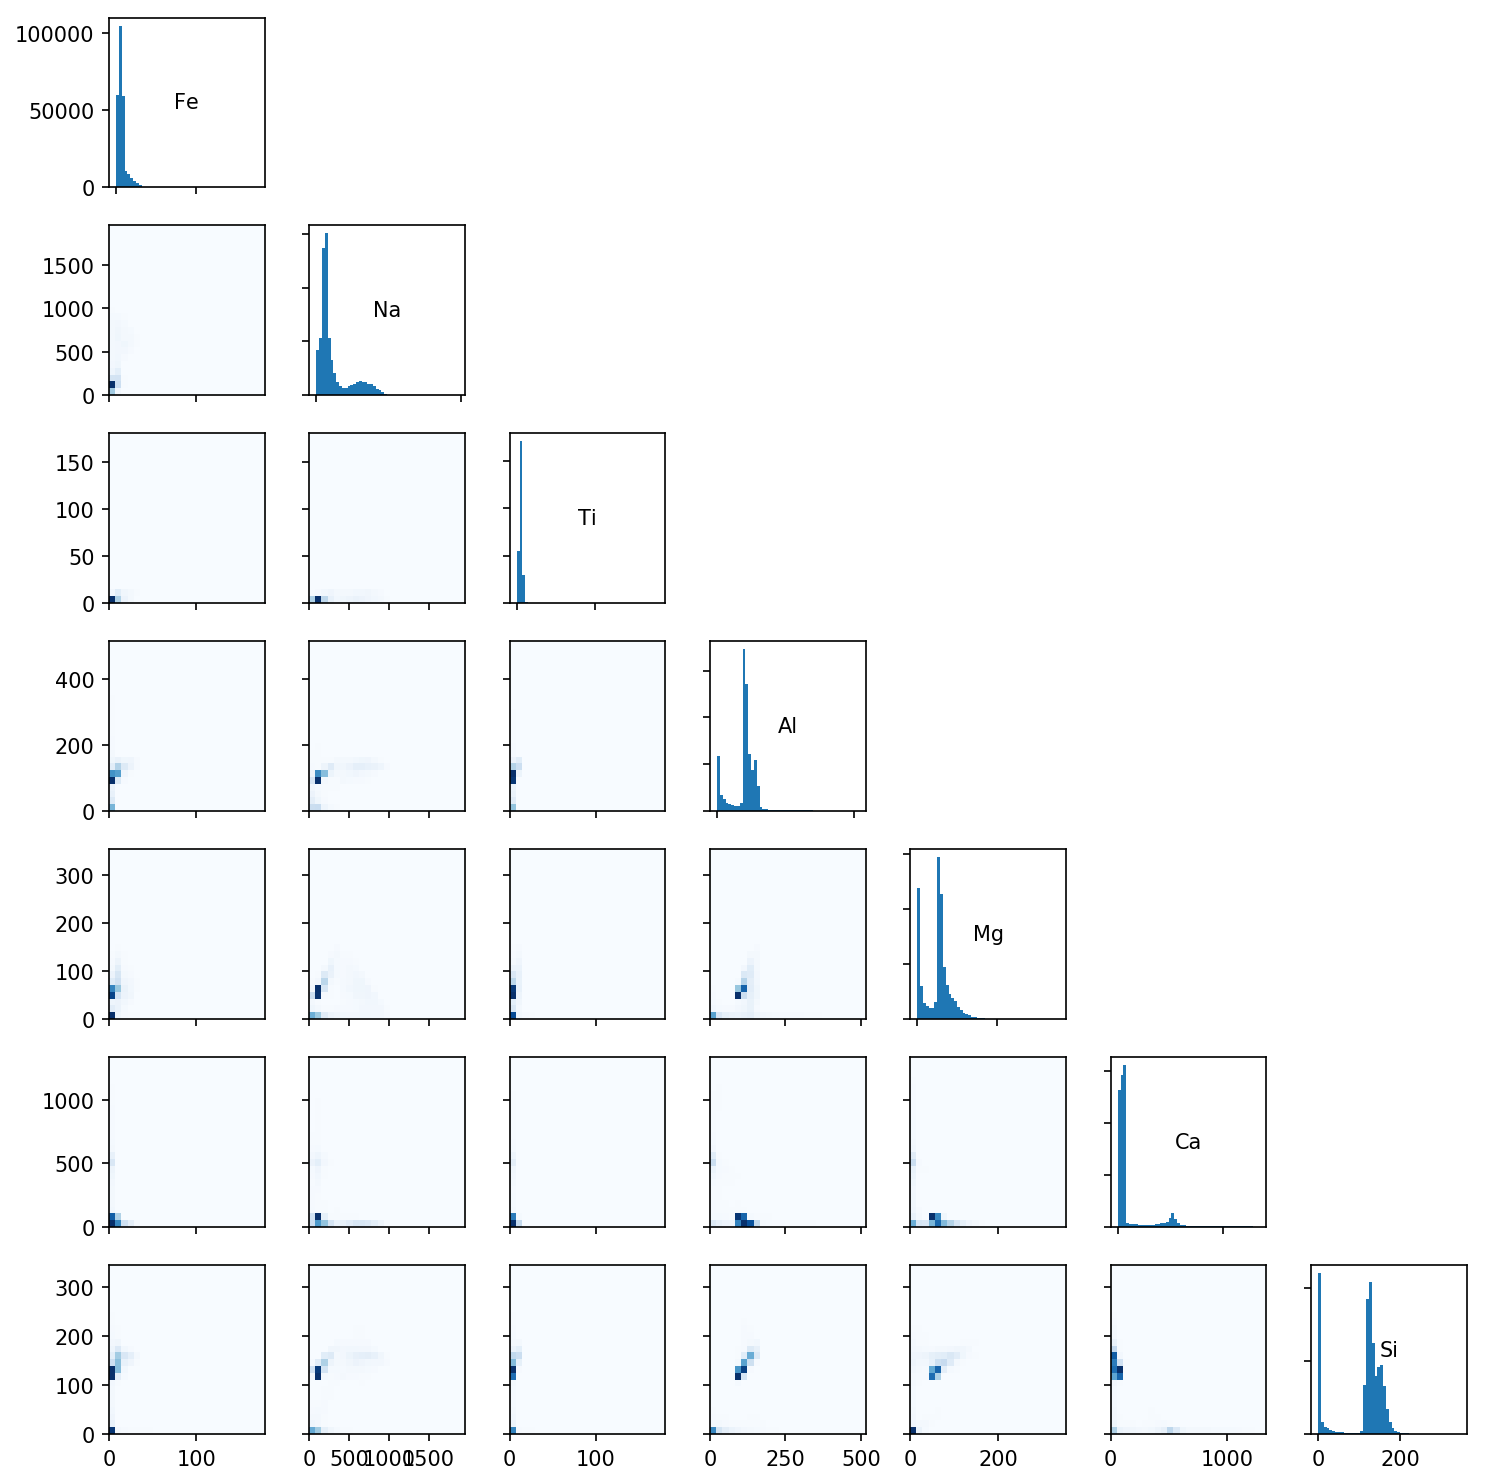

In [32]:
fig, axs = plt.subplots(7, 7, figsize=[10, 10])

for i, j in zip(*np.triu_indices(7)):
    if i != j:
        x = sdat[elements[i]].ravel()
        y = sdat[elements[j]].ravel()

        axs[j, i].hist2d(x, y, bins=25, cmap=plt.cm.Blues, normed=LogNorm())
        axs[i, j].set_visible(False)
    else:
        x = sdat[elements[i]].ravel()
        axs[i, j].hist(x, 50)
        axs[i, j].text(.5, .5, elements[i], transform=axs[i, j].transAxes, ha='center', va='center')
    
    
for ax in axs.flat:
    if not ax.is_last_row():
        ax.set_xticklabels([])
    if not ax.is_first_col():
        ax.set_yticklabels([])

fig.tight_layout()

## Remove 'Resin'

The compositional differences within the the sample are much less than the difference between the sample and the resin. To identify the more subtle differences within the sample, we must first remove the resin.

Because we don't have an a-priori estimate of resin composition (and all the element counts are uncalibrated anyway), we're going to use a clustering algorithm to identify the boundary between the materials.

In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [40]:
els = ['Fe', 'Na', 'Mg', 'Ca', 'Si']

# make all the data 1D (KMeans doesn't like 2D datasets).
# note that this means we lose all spatial information in the sample.
cd = []
for e in els:
    cd.append(sdat[e].ravel())

# combine them all into a single array, where each row is one pixel.
d = np.vstack(cd).T

# create a 'scaler' to transform the data so it's centered around zero, with a standard deviation of 1.
# if you don't do this, elements with higher counts will be disproportionately more important in the clustering.
scaler = StandardScaler().fit(d)

# transform the data
ds = scaler.transform(d)

In [41]:
# apply the clustering algorithm.
n_clusters = 6  # play around with the number of clusters, and see what happens!
km = KMeans(n_clusters, random_state=1)
kmf = km.fit(ds)

# get the 'cluster centers'
comps = kmf.cluster_centers_
# back-transform the cluster centers to real numbers
scomps = scaler.inverse_transform(comps)

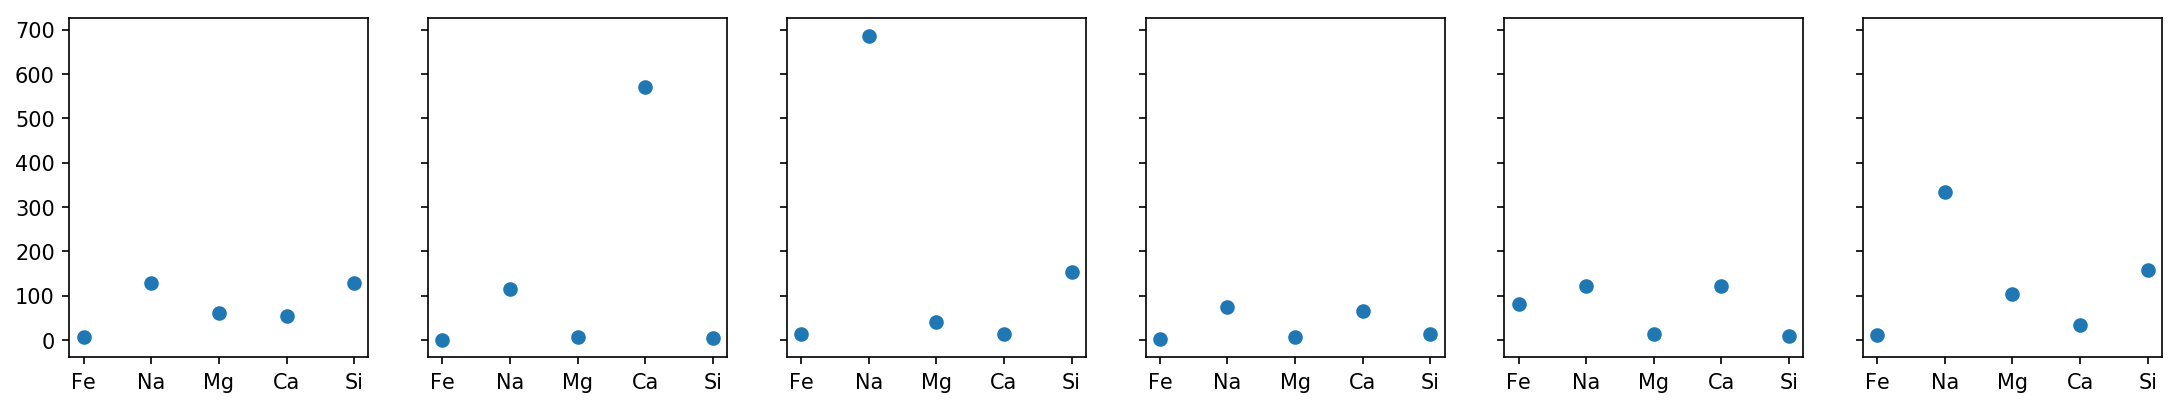

In [43]:
# look at the cluster centers (i.e. material compositions)
fig, axs = plt.subplots(1, comps.shape[0], figsize=[comps.shape[0] * 3, 3], sharey=True)

for comp, ax in zip(scomps, axs):
    ax.scatter(np.arange(comp.size), comp)
    ax.set_xticks(np.arange(comp.size))
    ax.set_xticklabels(els)

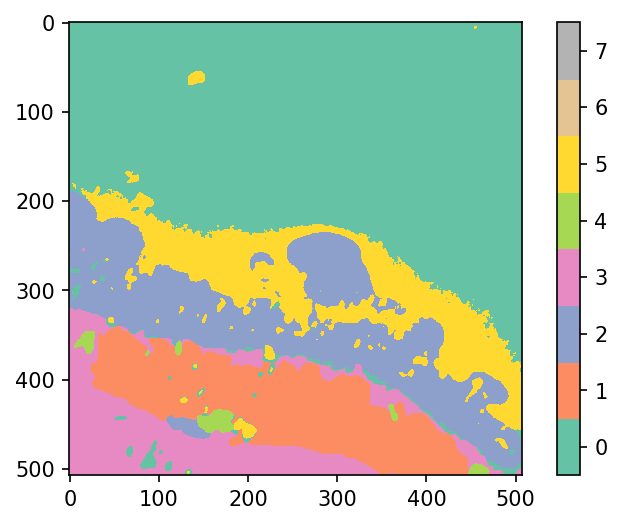

In [44]:
# and you can map them!
labels = np.reshape(kmf.labels_, [int(ds.shape[0]**0.5)] * 2)

plt.imshow(labels, cmap=plt.cm.Set2, vmin=-0.5, vmax=plt.cm.Set2.N - 0.5)
plt.colorbar()

## Masking

Now we've identified different materials, you can make a 'mask' to exclude or include them in further analyses

In [45]:
def fill_mask(mask, shifts=[1, -1]):
    """
    Function to expland the mask.
    """
    m = [mask]
    for s in shifts:
        m.append(np.roll(mask, s, 0))
        m.append(np.roll(mask, s, 1))
    
    return np.apply_along_axis(any, 0, np.array(m))

In [49]:
# mask that only keeps data in cluster 2 and 5.
mask = (labels == 2) | (labels == 5)

# exclude bottom fragment
frag = np.ones(mask.shape, dtype=bool)
frag[390:, :220] = False
frag[:150] = False
mask = mask & frag

mdat = {}

for k, v in dat.items():
    offset = (v.shape[0] - mask.shape[0]) // 2
    vm = v.copy()[offset:-offset, offset:-offset]
    vm[~mask] = np.nan
    mdat[k] = vm

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


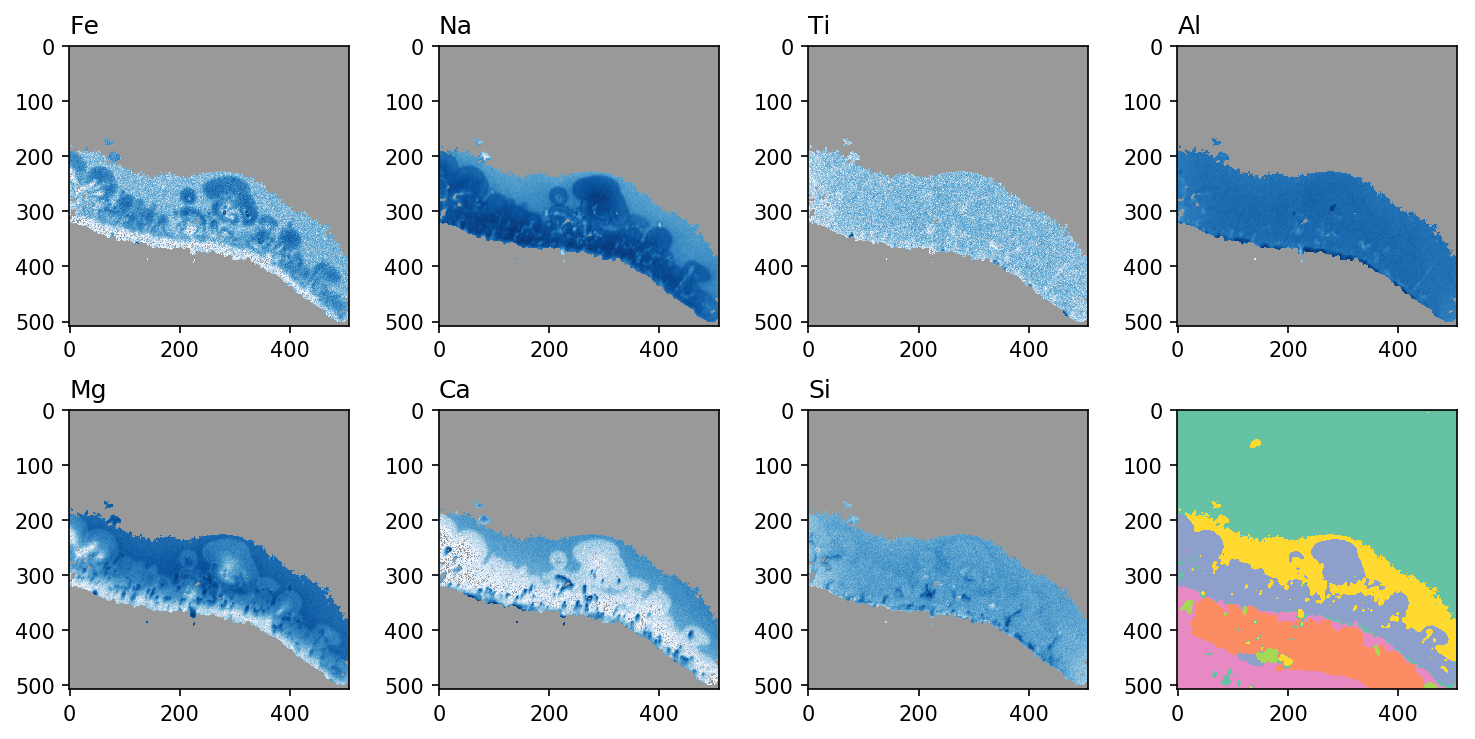

In [51]:
# look at masked data
fig, axs = plt.subplots(2, 4, figsize=[10, 5])

cm = plt.cm.Blues
cm.set_bad((0,0,0,0.4))

i = 0
for ax, (k, v) in zip(axs.flat, mdat.items()):
    ax.imshow(v, cmap=cm, norm=LogNorm())
    ax.set_title(k, loc='left')
    i += 1

axs[-1, -1].imshow(labels, cmap=plt.cm.Set2, vmin=-0.5, vmax=plt.cm.Set2.N - 0.5)

fig.tight_layout()

## What's interesting?
This picks out the 'sample' within the image, and allows us to explore more subtle differences within it.

In [52]:
imdat = {}
for k, v in mdat.items():
    imdat[k] = v.ravel()[~np.isnan(v.ravel())]

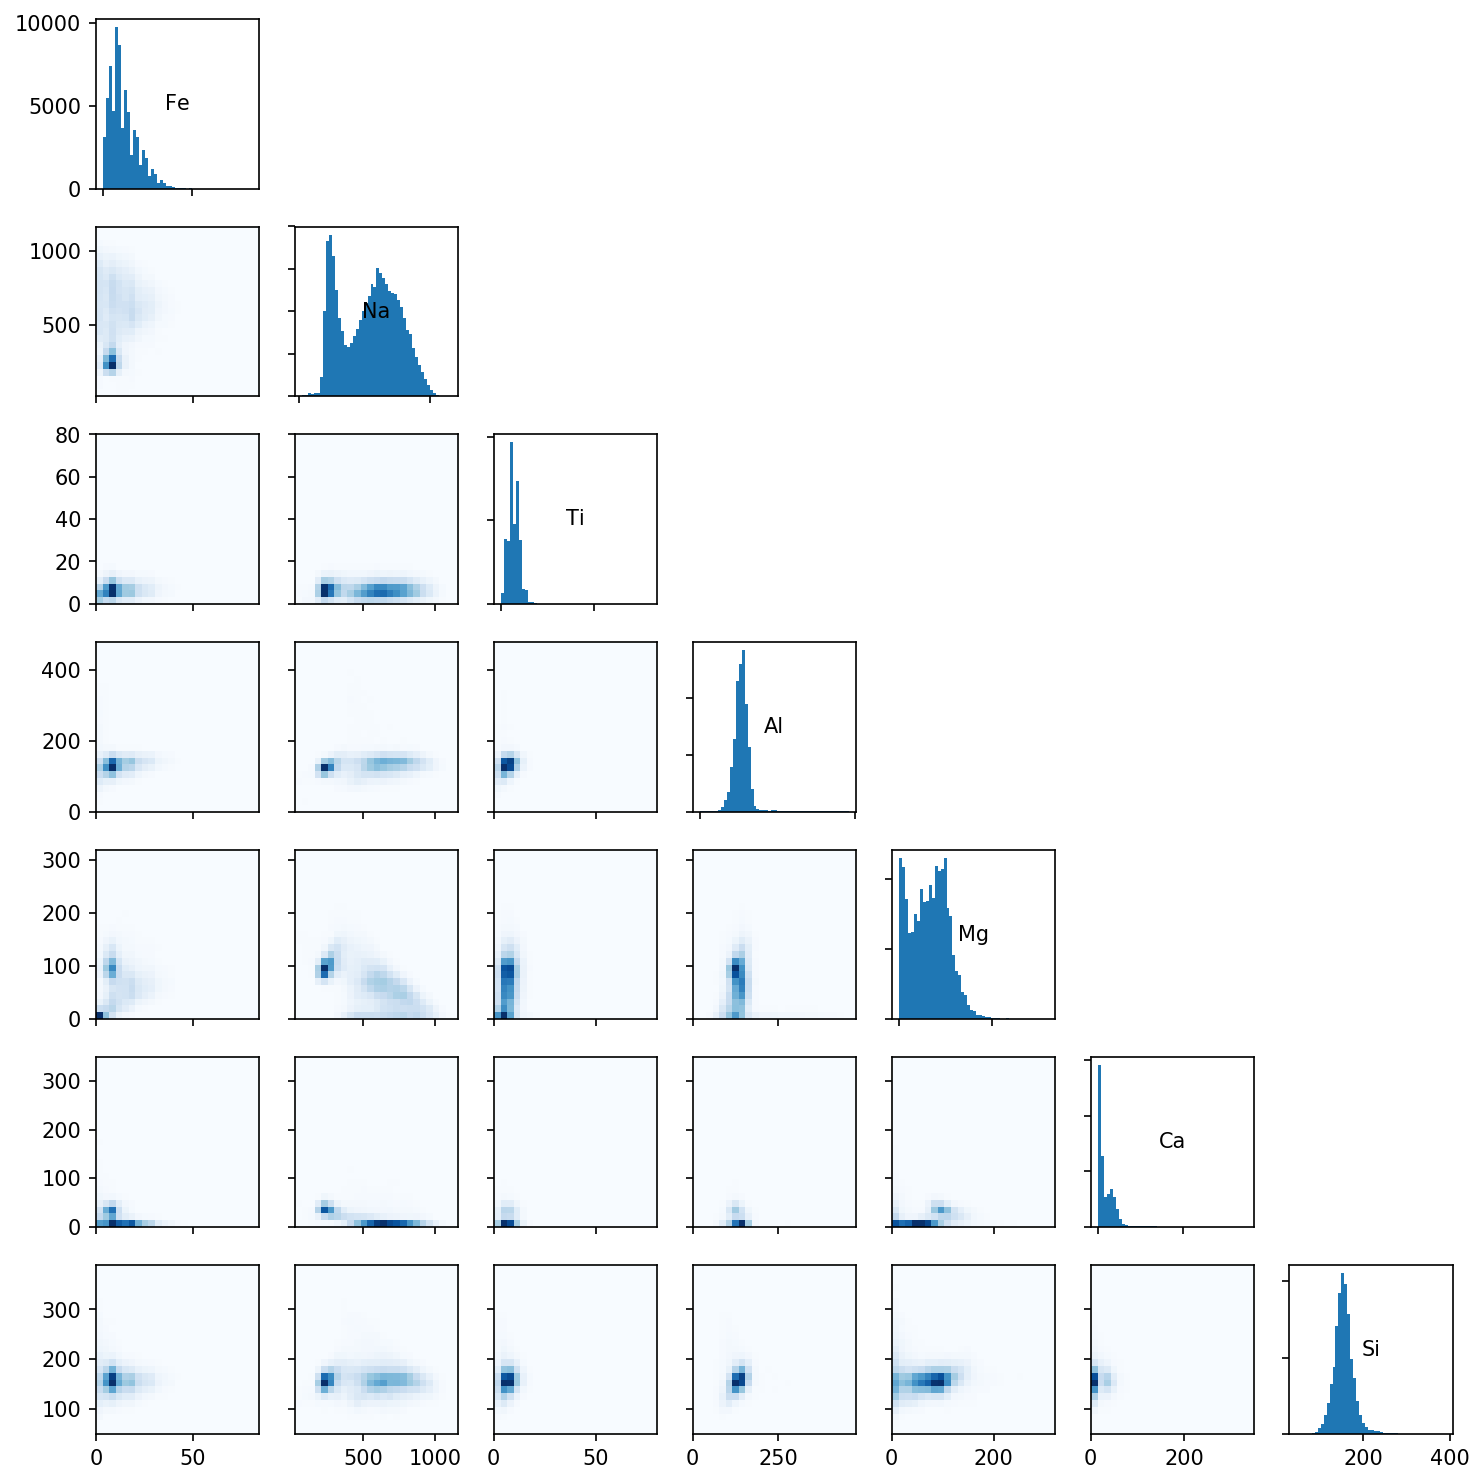

In [56]:
fig, axs = plt.subplots(7, 7, figsize=[10, 10])

for i, j in zip(*np.triu_indices(7)):
    x = imdat[elements[i]].ravel()
    if i != j:
        y = imdat[elements[j]].ravel()

        axs[j, i].hist2d(x, y, bins=25, cmap=plt.cm.Blues, normed=LogNorm())
        axs[i, j].set_visible(False)
    else:
        axs[i, j].hist(x, 50)
        axs[i, j].text(.5, .5, elements[i], transform=axs[i, j].transAxes, ha='center', va='center')
    
    
for ax in axs.flat:
    if not ax.is_last_row():
        ax.set_xticklabels([])
    if not ax.is_first_col():
        ax.set_yticklabels([])

fig.tight_layout()

## Ternary Plot

In [57]:
import ternary

In [58]:
els = ['Ca', 'Mg', 'Na']

cd = []
for e in els:
    cd.append(imdat[e].ravel())

d = np.vstack(cd).T

d /= d.sum(1)[:, np.newaxis]

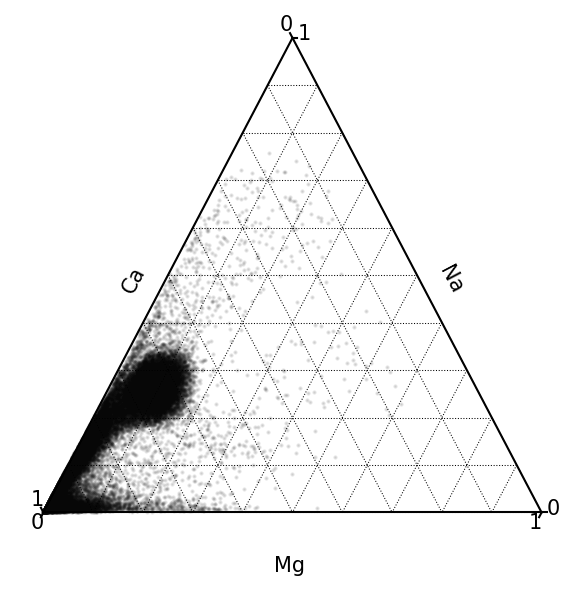

In [60]:
fig, ax = plt.subplots(1, 1, figsize=[4,4])

tax = ternary.TernaryAxesSubplot(ax=ax)

tax.scatter(d, alpha=0.1, s=1, edgecolor=(0,0,0,0), c='k')

tax.boundary(linewidth=1)
tax.gridlines(color="black", multiple=.1)

fontsize = 10
# ax.set_title("Simplex Boundary and Gridlines", fontsize=fontsize)
tax.left_axis_label(els[0], fontsize=fontsize)
tax.right_axis_label(els[2], fontsize=fontsize)
tax.bottom_axis_label(els[1], fontsize=fontsize)

tax.ticks(axis='lbr', linewidth=1)

ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

fig.tight_layout()

## Re-Do Clustering on clipped data

In [61]:
els = ['Fe', 'Ca', 'Na', 'Mg', 'Si']

cd = []
for e in els:
    cd.append(imdat[e].ravel())

d = np.vstack(cd).T

scaler = StandardScaler().fit(d)

ds = scaler.transform(d)

In [62]:
n_clusters = 5
km = KMeans(n_clusters, random_state=1)
kmf = km.fit(ds)

comps = kmf.cluster_centers_
scomps = scaler.inverse_transform(comps)

In [63]:
labels = np.full(mask.shape, np.nan)
labels[mask] = kmf.labels_

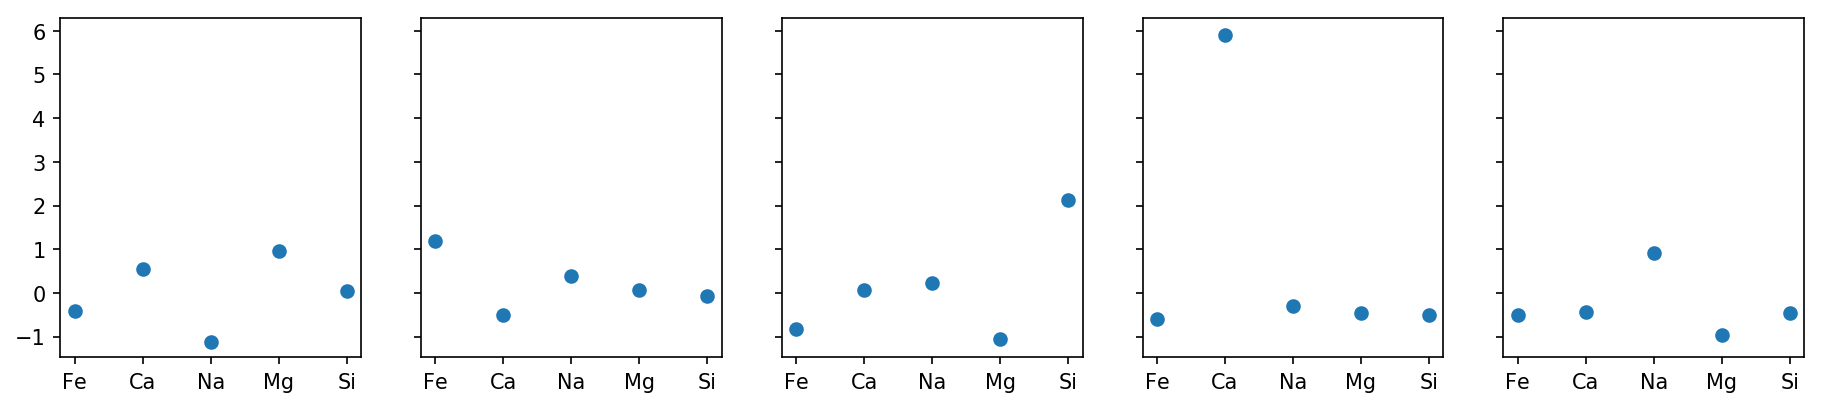

In [64]:
fig, axs = plt.subplots(1, comps.shape[0], figsize=[comps.shape[0] * 3, 3], sharey=True)

for comp, ax in zip(comps, axs):
    ax.scatter(np.arange(comp.size), comp)
    ax.set_xticks(np.arange(comp.size))
    ax.set_xticklabels(els)

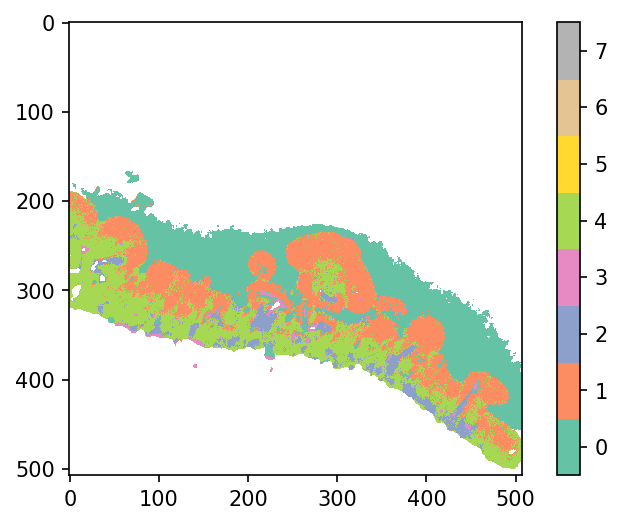

In [65]:
plt.imshow(labels, cmap=plt.cm.Set2, vmin=-0.5, vmax=plt.cm.Set2.N - 0.5)
plt.colorbar()

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


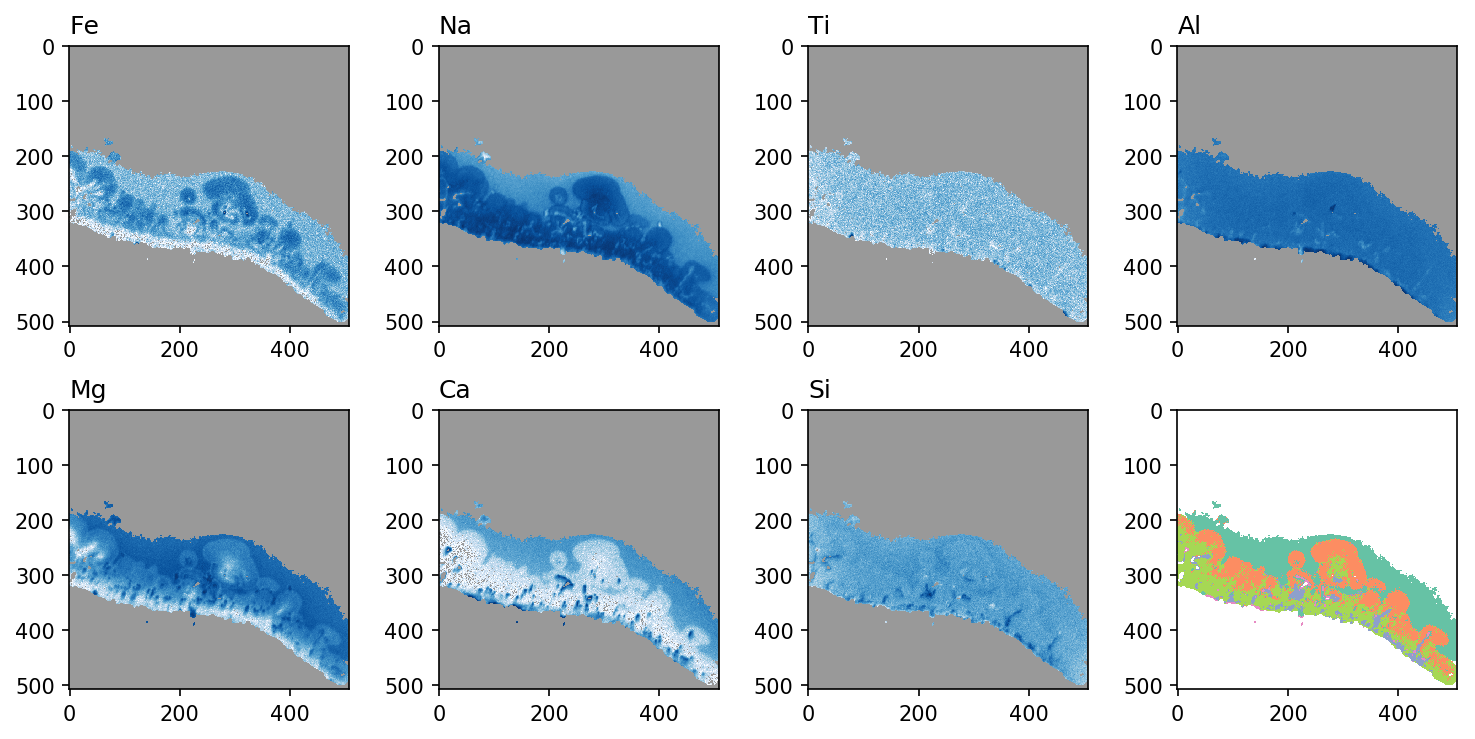

In [66]:
fig, axs = plt.subplots(2, 4, figsize=[10, 5])

cm = plt.cm.Blues
cm.set_bad((0,0,0,0.4))

i = 0
for ax, (k, v) in zip(axs.flat, mdat.items()):
    ax.imshow(v, cmap=cm, norm=LogNorm())
    ax.set_title(k, loc='left')
    i += 1

axs[-1, -1].imshow(labels, cmap=plt.cm.Set2, vmin=-0.5, vmax=plt.cm.Set2.N - 0.5)

fig.tight_layout()

In [67]:
mask = labels == 0

In [68]:
df = {}
for k, v in mdat.items():
    df[k] = v
    df[k][~mask] = np.nan

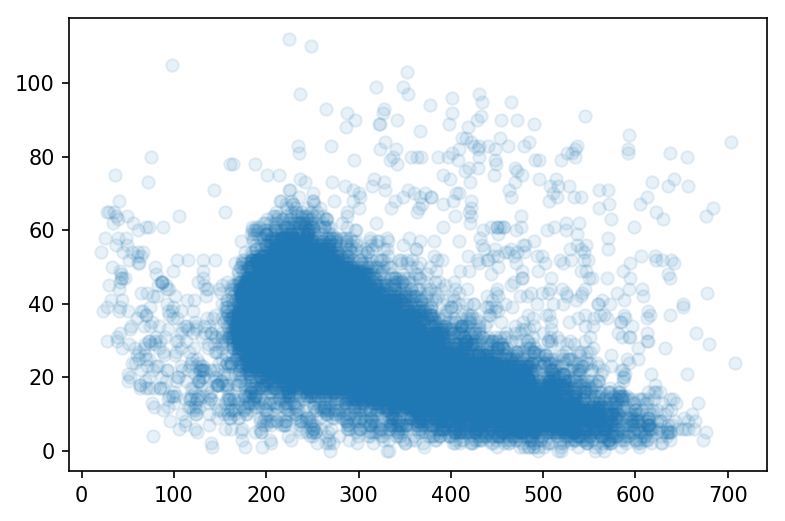

In [69]:
plt.scatter(df['Na'], df['Ca'], alpha=0.1)

In [70]:
# els = ['Na', 'Mg', 'Ca']
# els = ['Fe', 'Na', 'Mg']
els = ['Na', 'Ca', 'Si']

cd = []
for e in els:
    cd.append(imdat[e].ravel())

d = np.vstack(cd).T

d /= d.sum(1)[:, np.newaxis]

# ind = (kmf.labels_ == 0) | (kmf.labels_ == 1) | (kmf.labels_ == 4)
ind = kmf.labels_ != 3

d = d[ind]

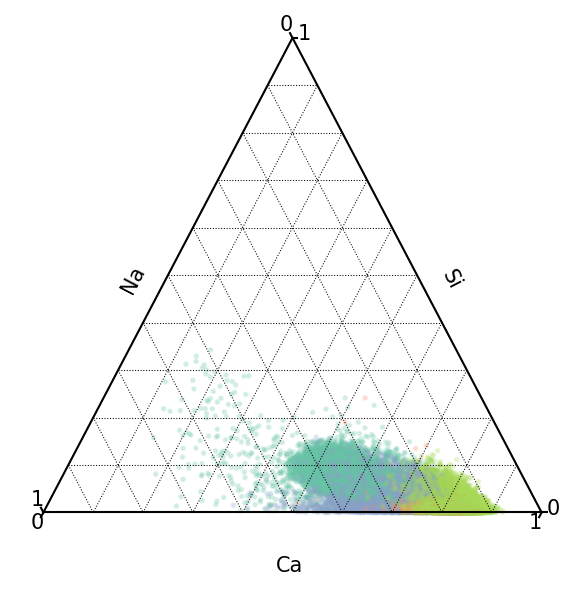

In [71]:
fig, ax = plt.subplots(1, 1, figsize=[4,4])

tax = ternary.TernaryAxesSubplot(ax=ax)

tax.scatter(d, s=3, c=plt.cm.Set2(kmf.labels_[ind]), vmin=-0.5, vmax=plt.cm.Set2.N - 0.5, alpha=0.2)

tax.boundary(linewidth=1)
tax.gridlines(color="black", multiple=.1)

fontsize = 10
# ax.set_title("Simplex Boundary and Gridlines", fontsize=fontsize)
tax.left_axis_label(els[0], fontsize=fontsize)
tax.right_axis_label(els[2], fontsize=fontsize)
tax.bottom_axis_label(els[1], fontsize=fontsize)

tax.ticks(axis='lbr', linewidth=1)

ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

fig.tight_layout()

# PCA?!

Have a play around with PCA...

In [72]:
import itertools
import matplotlib as mpl

In [73]:
def pca_plot(pca, dt, xlabs=None, mode='scatter', lognorm=True):
    """
    Plot a fitted PCA, and all components.
    """
    
    nc = pca.n_components
    f = np.arange(pca.components_.shape[0])
    cs = list(itertools.combinations(range(nc), 2))
    
    ind = ~np.apply_along_axis(any, 1, np.isnan(dt))

    cylim = (pca.components_.min(), pca.components_.max())
    yd = cylim[1] - cylim[0]
    
    # Make figure
    fig, axs = plt.subplots(nc, nc, figsize=[3 * nc, nc * 3], tight_layout=True)
            
    for x, y in zip(*np.triu_indices(nc)):
        if x == y:
            tax = axs[x, y]
            tax.bar(f, pca.components_[x], 0.8)
            tax.set_xticks([])
            tax.axhline(0, zorder=-1, c=(0,0,0,0.6))

            # labels            
            tax.set_ylim(cylim[0] - 0.2 * yd,
                         cylim[1] + 0.2 * yd)

            for xi, yi, lab in zip(f, pca.components_[x], xlabs):
                if yi > 0:
                    yo = yd * 0.03
                    va = 'bottom'
                else:
                    yo = yd * -0.02
                    va = 'top'

                tax.text(xi, yi + yo, lab, ha='center', va=va, rotation=90, fontsize=8)

        else:
            xv = dt[ind, x]
            yv = dt[ind, y]

            if mode == 'scatter':
                axs[x, y].scatter(xv, yv, alpha=0.2)
                axs[y, x].scatter(yv, xv, alpha=0.2)
            if mode == 'hist2d':
                if lognorm:
                    norm = mpl.colors.LogNorm()
                else:
                    norm = None
                axs[x, y].hist2d(xv, yv, 50, cmap=plt.cm.Blues, norm=norm)
                axs[y, x].hist2d(yv, xv, 50, cmap=plt.cm.Blues, norm=norm)

        if x == 0:
            axs[y, x].set_ylabel('PC{:.0f}'.format(y + 1))
        if y == nc - 1:
            axs[y, x].set_xlabel('PC{:.0f}'.format(x + 1))
        
    return fig, axs, xv, yv

In [74]:
from sklearn.decomposition import PCA

In [75]:
els = ['Fe', 'Na', 'Mg', 'Ca', 'Si', 'Ti', 'Al']

cd = []
for e in els:
    cd.append(sdat[e].ravel())

d = np.vstack(cd).T

scaler = StandardScaler().fit(d)

ds = scaler.transform(d)

In [76]:
n_components = 7
pca = PCA(n_components)
pca.fit(ds)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [77]:
pct = pca.transform(ds)

In [ ]:
_ = pca_plot(pca, ds, els)

In [ ]:
plt.plot(pca.explained_variance_ratio_)

## ICA?

Playing around with ICA!

In [ ]:
from sklearn.decomposition import FastICA

In [ ]:
n_components = 4
ica = FastICA(n_components, whiten=True)
ica.fit(ds)

In [ ]:
ica.components_.shape

In [ ]:
pct = ica.transform(ds)

In [ ]:
plt.imshow(np.reshape(pct[:,0], [int(pct.shape[0]**0.5)] * 2))
plt.colorbar()